In [2]:
import numpy as np
import pandas as pd 
from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from plot import * 
import os
import glob
import re

data_folder = "/project/iclip/kaitian/datasets/xenium5k_ff_ovarian_processed/"

In [3]:
from utils import load_image
from computeMetrics import compute_metrics
from densityFiltering import compute_low_density_mask
from textureAnalysis import run_texture_analysis
from ratioFiltering import run_ratio_filtering
from generateMask import generate_final_mask

/home/kaitian/miniconda3/envs/istar/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# ===== USER-DEFINED INPUT PARAMETERS =====

# Path prefix to your H&E image folder
HE_prefix = "/project/iclip/kaitian/datasets/xenium5k_ff_ovarian_processed/"

# Flag for whether to rescale the image 
need_scaling_flag = False  # True if image resolution ≠ 0.5µm (or desired size) per pixel

# Flag for whether to preprocess the image 
need_preprocessing_flag = False  # True if image dimensions are not divisible by patch_size

# The pixel size (in microns) of the raw H&E image 
pixel_size_raw = 0.5  # Typically provided by the scanner/metadata (e.g., 0.25 µm/pixel for 40x)

# Parameter used determine amount of density filtering (e.g artifacts)
density_thresh = 100 # Typically 100 works well, but may need to increase if artifacts are not being effectively removed (e.g. fiducial marker)

# Flag for whether to clean background (i.e. remove isolated debris and small specs outside tissue)
clean_background_flag = True # Set to False if you want to preserve fibrous regions that are otherwise being incorrectly filtered out

# Parameter used to remove isolated debris and small specs outside tissue
min_size = 10 # Decrease if there are many fibrous areas (e.g. adipose) in the tissue that you wish to retain (e.g. 5), increase if lots of/larger debris you wish to remove (e.g.50)


# ===== Additional PARAMETERS (typically do not need to change) =====

# Size of one square patch (superpixel) used throughout processing
patch_size = 16  # 16x16 pixels → typically 8µm if pixel_size = 0.5

# Target pixel size (in microns)
pixel_size = 0.5  # Final desired resolution; keep as 0.5 µm for standardization

In [5]:
image = load_image(os.path.join(HE_prefix, "he.png"))
print(image.shape)

Image loaded from /project/iclip/kaitian/datasets/xenium5k_ff_ovarian_processed/he.png
(22624, 43232, 3)


In [6]:
directory = f"{HE_prefix}/HistoSweep_Output"
if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
he_std_norm_image_, he_std_image_, z_v_norm_image_, z_v_image_, ratio_norm_, ratio_norm_image_ = compute_metrics(image)


In [8]:
mask1_lowdensity = compute_low_density_mask(z_v_image_, he_std_image_, ratio_norm_, density_thresh=density_thresh)


In [9]:
print('Total number of superpixels selected for density filtering:', mask1_lowdensity.sum())


Total number of superpixels selected for density filtering: 75498


In [10]:
mask1_lowdensity_update = run_texture_analysis(prefix=HE_prefix, image=image, tissue_mask=mask1_lowdensity,  glcm_levels=64)


✅ Entropy map saved as 'glcm_entropy_map_colored.png'
✅ Energy map saved as 'glcm_energy_map_colored.png'
✅ Homogeneity map saved as 'glcm_homogeneity_map_colored.png'

=== GLCM Metric Means ===
   homogeneity    energy   entropy
0     0.359158  0.052675  0.828474
1     0.505872  0.125076  0.689860
2     0.577256  0.232099  0.583142

=== Cluster Scores ===
Cluster 0: Score = -0.4166
Cluster 1: Score = -0.0589
Cluster 2: Score = 0.2262

=== Number of Observations per Cluster ===
Cluster 0: 33676
Cluster 1: 21405
Cluster 2: 10141
Total: 65222

✅ Clustered texture map saved as 'cluster_labels_colored.png'


In [11]:
# identify low ratio superpixels
mask2_lowratio, otsu_thresh = run_ratio_filtering(ratio_norm_, mask1_lowdensity_update)


In [12]:
# generate final mask files
generate_final_mask(prefix=HE_prefix, he=image, 
                    mask1_updated = mask1_lowdensity_update, mask2 = mask2_lowratio, 
                    clean_background = clean_background_flag, 
                    super_pixel_size=patch_size, minSize = min_size)

✅ Final masks saved in: HistoSweep_Output


In [13]:
he_embed_total = np.load(data_folder + "embedding.npy")

In [14]:
he_embed_total.shape

(1351, 2569, 2048)

In [15]:
### after process the mask image ###

masked_image = load_image(data_folder+'HistoSweep_Output/mask-small.png')

masked_image.shape


Image loaded from /project/mingyaolpc/shuang/gastric_cancer/PA292A/HistoSweep_Output/mask-small.png


(1351, 2569)

In [16]:
mask_index = masked_image > 0  # shape: (1169, 1470), dtype: bool


In [17]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

num_he_clusters = 30
feature_shape = (1351, 2569)

he_embed_wsi_filtered = he_embed_total[mask_index]

pca_encoder = PCA(n_components=80)
pca_encoder.fit(he_embed_wsi_filtered)
he_embed_wsi_filtered_pca = pca_encoder.fit_transform(he_embed_wsi_filtered)

he_clusters = KMeans(n_clusters=num_he_clusters, n_init=20).fit_predict(he_embed_wsi_filtered_pca).astype('int')
he_clusters_image = np.zeros(feature_shape)


In [18]:
he_clusters_image = np.full(masked_image.shape, -1, dtype=int)  # (1414, 2702) initialized with -1
he_clusters_image[mask_index] = he_clusters  # must match


In [19]:
he_clusters_image.shape

(1351, 2569)

In [20]:
he_clusters_image[mask_index] = he_clusters

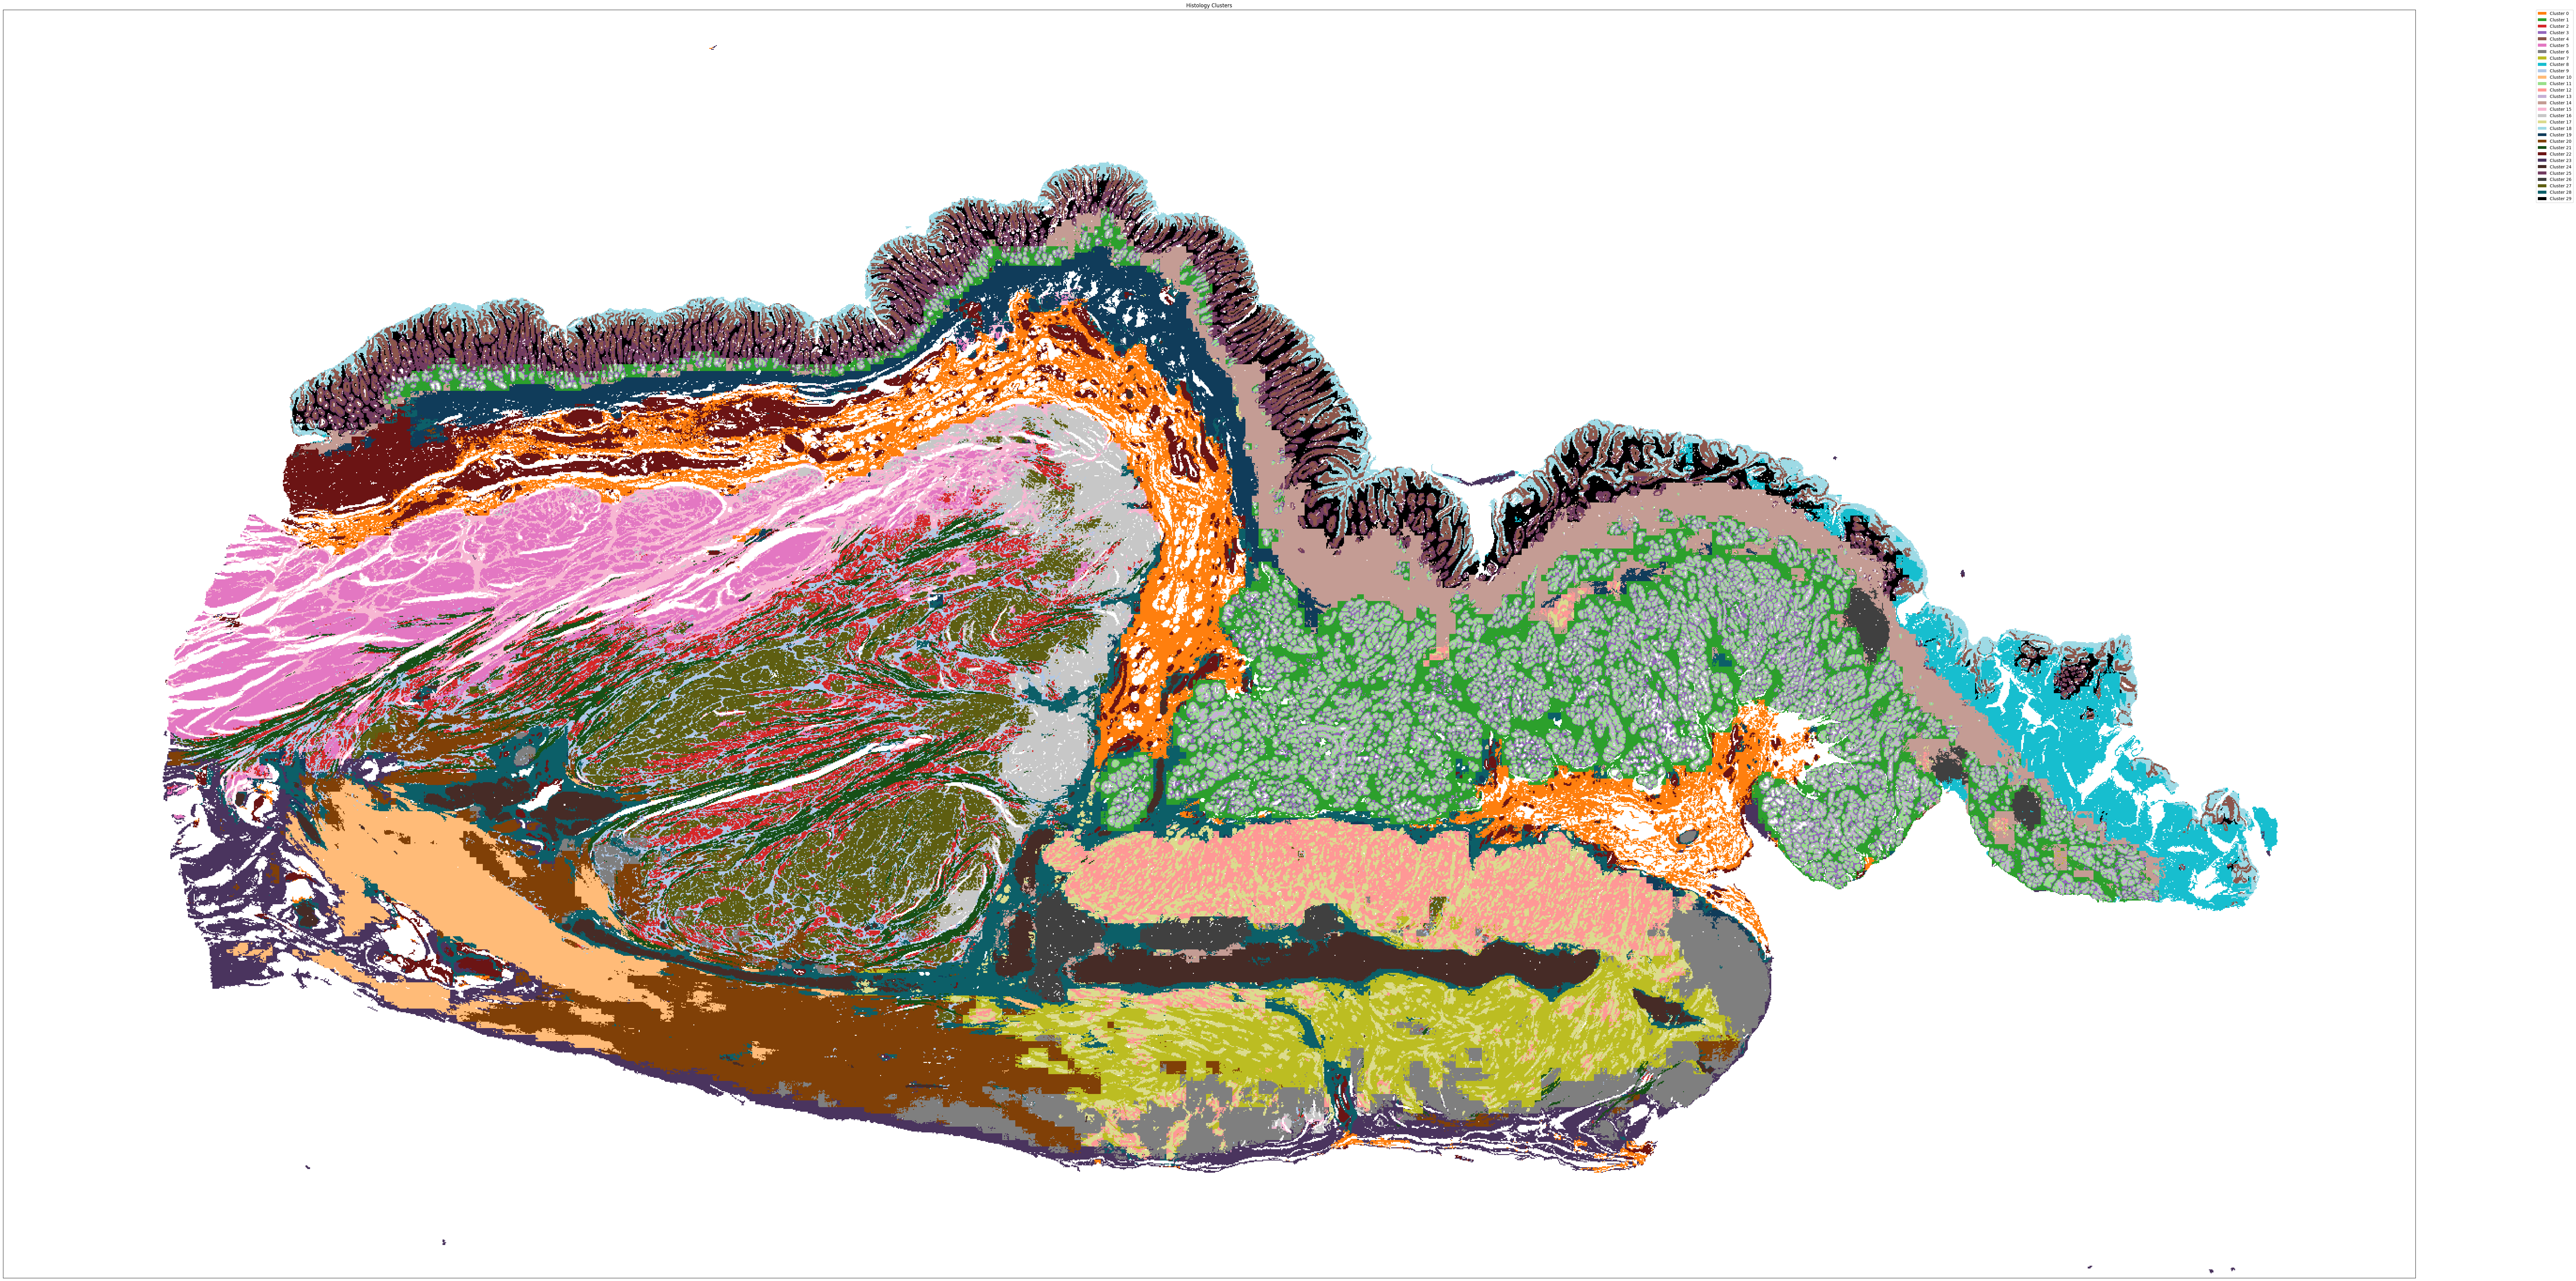

In [21]:
plot_histology_clusters(he_clusters_image, num_he_clusters, save_path=data_folder+'PA292A_Visium_he_clusters_c30_histosweep_V2_expedite.jpg')

In [22]:
np.save(data_folder+f"he_clusters_image_num_clusters_{num_he_clusters}_autofilter.npy", he_clusters_image)

/home/shuang91/miniconda3/envs/py39_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

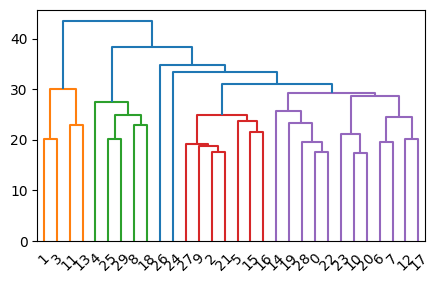

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from umap import UMAP

he_clusters = he_clusters_image[mask_index]
he_clusters_centroids = []
for cluster in range(num_he_clusters):
    he_clusters_centroid = np.mean(he_embed_wsi_filtered[he_clusters==cluster], axis=0)
    he_clusters_centroids.append(he_clusters_centroid)

plt.figure()
Z = linkage(he_clusters_centroids, 'average')
fig = plt.figure(figsize=(5, 3))
dn = dendrogram(Z)
plt.savefig(data_folder+'PA292A_Visium_hierachy_clusters_c30_histosweep_V2_expedite.jpg')